<a href="https://colab.research.google.com/github/jejjohnson/research_notebook/blob/develop/research_notebook/research_notebook/content/tutorials/regression_masterclass/regression_master_class_gpflux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Master Class in Regression and Uncertainty with Tensorflow Probability

In this notebook, I will exploring the new [tensorflow 2.0](), [tensorflow probability]() and [edward2](). We have come a long way 

### Resources

**BNN**

* A regression masterclass with Aboleth - [docs](https://aboleth.readthedocs.io/en/stable/tutorials/some_regressors.html)
* Bayesian Regressions with MCMC or Variational Bayes using TensorFlow Probability - [blog](https://brendanhasz.github.io/2018/12/03/tfp-regression)
* Regression with Probabilistic Layers in TensorFlow Probability - [blog](https://medium.com/tensorflow/regression-with-probabilistic-layers-in-tensorflow-probability-e46ff5d37baf) | [Notebook](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Probabilistic_Layers_Regression.ipynb)
* Variational Inference for Bayesian Neural Networks - [Blog](http://krasserm.github.io/2019/03/14/bayesian-neural-networks/)

**TF2**

* Bayesian Gaussian Mixture Modeling with SVI (06-2019) - [blog](https://brendanhasz.github.io/2019/06/12/tfp-gmm.html)
* Trip Duration Prediction using Bayesian NN and TF2.0 (06-2019) - [Blog](https://brendanhasz.github.io/2019/07/23/bayesian-density-net.html)

**Keras**

* A Tutorial on Variational Autoencoders with Concise Keras Implementation - [blog](https://tiao.io/post/tutorial-on-variational-autoencoders-with-a-concise-keras-implementation/)
* Building VAE in TensorFlow - [blog](https://danijar.com/building-variational-auto-encoders-in-tensorflow/)

In [ ]:
# Install TensorFlow
!pip install tensorflow-probability gpflux loguru

     |████████████████████████████████| 71kB 8.5MB/s 
     |████████████████████████████████| 61kB 10.1MB/s 
     |████████████████████████████████| 276kB 25.1MB/s 


In [ ]:
#@title Import Packages

from pprint import pprint
import numpy as np


# TensorFlow Imports
import tensorflow as tf

# TensorFlow Probability Imports
import tensorflow_probability as tfp
tfd = tfp.distributions

# Keras Imports

# gpflow Imports
import gpflow
import gpflux

# GPFlow Imports

# NUMPY SETTINGS
import numpy as onp
onp.set_printoptions(precision=3, suppress=True)

# MATPLOTLIB Settings
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# SEABORN SETTINGS
import seaborn as sns
sns.set_context(context='talk',font_scale=0.7)
# sns.set(rc={'figure.figsize': (12, 9.)})
# sns.set_style("whitegrid")

# PANDAS SETTINGS
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

# LOGGING SETTINGS
import sys
import loguru

%load_ext autoreload
%autoreload 2

In [ ]:
if tf.test.gpu_device_name() != '/device:GPU:0':
  print('WARNING: GPU device not found.')
else:
  print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

SUCCESS: Found GPU: /device:GPU:0


## Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def f(x, noise=0.05): return np.sin(x) / x + noise * np.random.randn(x.shape[0], x.shape[1])

ntrain, ntest, ntrue = 500, 500, 1_000

xtrain = np.linspace(-10, 10, ntrain)[:, None]
ytrain = f(xtrain)

xtest = np.linspace(-15, 15, ntest)[:, None]
ytest = f(xtest, noise=0.0)

xtrue = np.linspace(-15, 15, ntrue)[:, None]
ytrue = f(xtrue, noise=0.0)

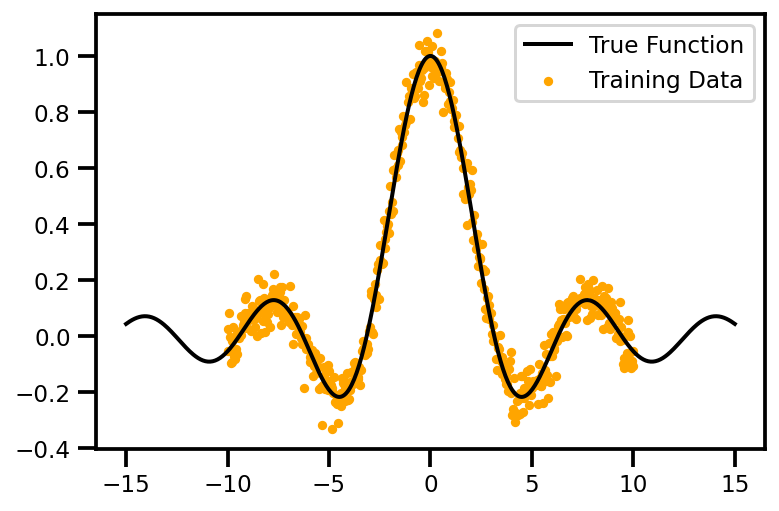

In [ ]:
fig, ax = plt.subplots()

ax.scatter(xtrain, ytrain, s=10, color="orange", label="Training Data")
ax.plot(xtest, ytest, linewidth=2, color="black", label="True Function")

ax.legend()
plt.show()

### Plot Functions

In [ ]:
def plot_results(ypred, stddevs=None, **kwargs):
    
    fig, ax = plt.subplots()
    
    ax.scatter(xtrain, ytrain, s=0.01, label='Training Points', color='blue')
    ax.plot(xtest, ypred, label='Predicted Points', color='red')
    ax.plot(xtrue, ytrue, label='Latent Function', color='black')
    if stddevs is not None:
        ax.fill_between(
            xtest.squeeze(), 
            (ypred - 2 * stddevs).squeeze(), 
            (ypred + 2 * stddevs).squeeze(),
            color='red', alpha=0.2,
            label='Confidence Interval', 
        )
    ax.legend()
    ax.set(**kwargs)
    plt.show()
    
    
    return None

def plot_loss(history):
    
    # plot training history
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'], label='train')
    plt.legend()
    plt.show()
    

## Gaussian Process (Standard)

In [ ]:
# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')

num_inducing = 32
output_dim = ytrain.shape[1]

kernel = gpflow.kernels.SquaredExponential()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.linspace(xtrain.min(), xtrain.max(), num_inducing).reshape(-1, 1)
)
gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=ntrain, num_latent_gps=output_dim
)

In [ ]:
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian(0.1))

In [ ]:
single_layer_dgp = gpflux.models.DeepGP([gp_layer], likelihood_layer)
model = single_layer_dgp.as_training_model()

model.compile(tf.optimizers.Adam(0.01))

In [ ]:
rlr=tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=3, min_lr=1e-6, verbose=0)
es = tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20)

history = model.fit(
    {"inputs": xtrain, "targets": ytrain}, 
    epochs=1_500, 
    verbose=0,
    batch_size=32,
    callbacks=[rlr, es]
)


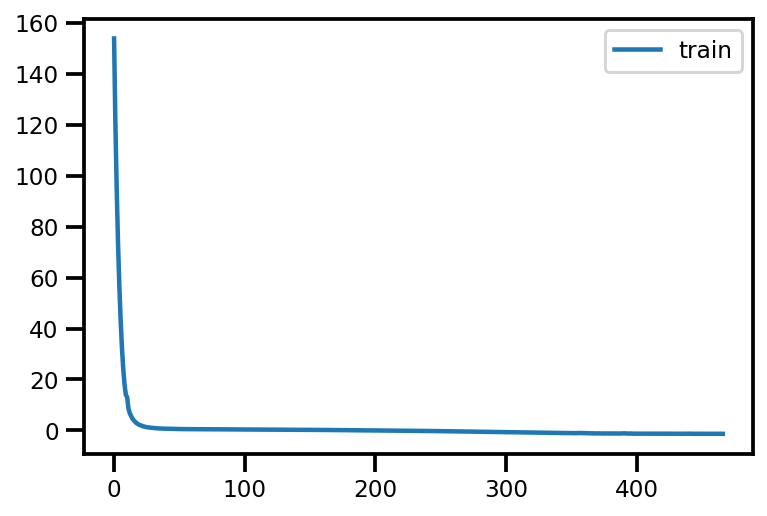

In [ ]:
plot_loss(history)

In [ ]:
pred_model = single_layer_dgp.as_prediction_model()

out = pred_model(xtest)

mu = out.f_mean.numpy().squeeze()
var = np.sqrt(out.f_var.numpy().squeeze())

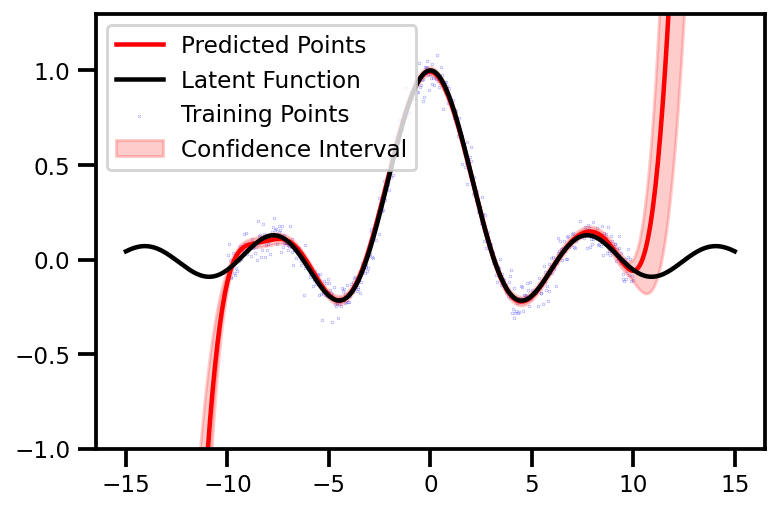

In [ ]:
plot_results(mu, var, ylim=[-1.0, 1.3])

## Deep GP (2-Layer)

In [ ]:
from gpflux.architectures import Config, build_constant_input_dim_deep_gp
from gpflux.models import DeepGP


num_layers = 2
num_inducing = 32

config = Config(
    num_inducing=num_inducing, inner_layer_qsqrt_factor=1e-5, likelihood_noise_variance=1e-2, whiten=True
)
deep_gp: DeepGP = build_constant_input_dim_deep_gp(xtrain, num_layers=num_layers, config=config)

In [ ]:
# From the `DeepGP` model we instantiate a training model which is a `tf.keras.Model`
training_model: tf.keras.Model = deep_gp.as_training_model()

# Following the Keras procedure we need to compile and pass a optimizer,
# before fitting the model to data
training_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01))

callbacks = [
    # Create callback that reduces the learning rate every time the ELBO plateaus
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=3, min_lr=1e-6, verbose=0),
    # Create a callback that writes logs (e.g., hyperparameters, KLs, etc.) to TensorBoard
    tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20),
    # # Create a callback that writes logs (e.g., hyperparameters, KLs, etc.) to TensorBoard
    # gpflux.callbacks.TensorBoard(),
    # # Create a callback that saves the model's weights
    # tf.keras.callbacks.ModelCheckpoint(filepath="ckpts/", save_weights_only=True, verbose=0),
]

history = training_model.fit(
    {"inputs": xtrain, "targets": ytrain},
    batch_size=32,
    epochs=1_500,
    callbacks=callbacks,
    verbose=0,
)

In [ ]:
pred_model = deep_gp.as_prediction_model()

out = pred_model(xtest)

mu = out.f_mean.numpy().squeeze()
var = np.sqrt(out.f_var.numpy().squeeze())

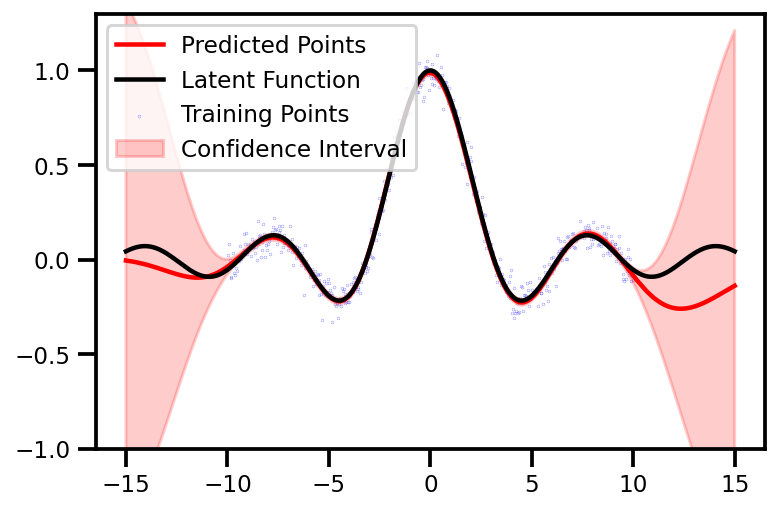

In [ ]:
plot_results(mu, var, ylim=[-1.0, 1.3])

## Deep Kernel Learning

In [ ]:
# For numeric stability, set the default floating-point dtype to float64
tf.keras.backend.set_floatx('float64')

num_inducing = 32#xtrain.shape[0]
output_dim = ytrain.shape[1]

kernel = gpflow.kernels.RationalQuadratic()
inducing_variable = gpflow.inducing_variables.InducingPoints(
    np.linspace(xtrain.min(), xtrain.max(), num_inducing).reshape(-1, 1)
)

gp_layer = gpflux.layers.GPLayer(
    kernel, inducing_variable, num_data=ntrain, num_latent_gps=output_dim, 
)

In [ ]:
likelihood = gpflow.likelihoods.Gaussian(0.001)
optimizer = tf.optimizers.Adam(0.01)
# So that Keras can track the likelihood variance, we need to provide the likelihood as part of a "dummy" layer:
likelihood_container = gpflux.layers.TrackableLayer()
likelihood_container.likelihood = likelihood

model = tf.keras.Sequential(
    [
        tf.keras.layers.InputLayer(1),
        tf.keras.layers.Dense(64, activation="sigmoid"),
        tf.keras.layers.Dense(64, activation="sigmoid"),
        tf.keras.layers.Dense(1, activation="linear"),
        gp_layer,
        likelihood_container,  # no-op, for discovering trainable likelihood parameters
    ]
)
loss = gpflux.losses.LikelihoodLoss(likelihood)

In [ ]:
model.compile(loss=loss, optimizer=optimizer)

In [ ]:
callbacks = [
    # Create callback that reduces the learning rate every time the ELBO plateaus
    tf.keras.callbacks.ReduceLROnPlateau("loss", factor=0.95, patience=3, min_lr=1e-6, verbose=0),
    # Create a callback that writes logs (e.g., hyperparameters, KLs, etc.) to TensorBoard
    tf.keras.callbacks.EarlyStopping(monitor='loss', mode='min', patience=20),
    # # Create a callback that writes logs (e.g., hyperparameters, KLs, etc.) to TensorBoard
    # gpflux.callbacks.TensorBoard(),
    # # Create a callback that saves the model's weights
    # tf.keras.callbacks.ModelCheckpoint(filepath="ckpts/", save_weights_only=True, verbose=0),
]

history = model.fit(
    xtrain, ytrain,
    batch_size=64,
    epochs=2_500,
    callbacks=callbacks,
    verbose=0,
)

In [ ]:
out = model(xtest)

mu = out.mean().numpy().squeeze()
var = out.stddev().numpy().squeeze()

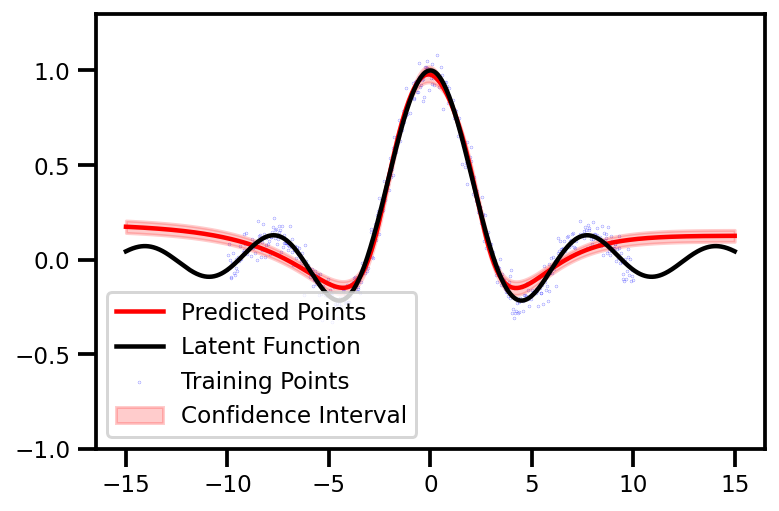

In [ ]:
plot_results(mu, var, ylim=[-1.0, 1.3])